In [ ]:
import re
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns
import string
import nltk
import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

In [ ]:
train = pd.read_csv('https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/train.csv')

train_original=train.copy()

test = pd.read_csv('https://raw.githubusercontent.com/dD2405/Twitter_Sentiment_Analysis/master/test.csv')

test_original=test.copy()

In [ ]:
train

In [ ]:
train_original.loc[1]['tweet']

In [ ]:

combine = train.append(test,ignore_index=True,sort=True) #using pandas .append() to combine training and testing samples

In [ ]:
combine

In [ ]:
#function to remove twitter handles
def remove_pattern(text,pattern):
    
    # re.findall() finds the pattern i.e @user and puts it in a list for further task
    r = re.findall(pattern,text)
    
    # re.sub() removes @user from the sentences in the dataset
    for i in r:
        text = re.sub(i,"",text)
    
    return text

In [ ]:
remove_pattern('@user...can\'t believe@user this','@user') #works!!!

In [ ]:
#NumPy vectorization for speed!
combine['Tidy_Tweets'] = np.vectorize(remove_pattern)(combine['tweet'], "@[\w]*")

combine.head()
# [\w]* Matches any alphanumeric character; this is equivalent to the class [a-zA-Z0-9_]

In [ ]:
#removing punctuation
# [^a-zA-Z] means any character that IS NOT a-z OR A-Z also starts with # (outside bracket)
combine['Tidy_Tweets'] = combine['Tidy_Tweets'].str.replace("[^a-zA-Z]#", " ")

combine.head(10)

In [ ]:
#NLTK tokenizer for stop words like the,and etc...
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize

text = "Nick likes to play football, however he is not too fond of tennis."
text_tokens = word_tokenize(text)

tokens_without_sw = [word for word in text_tokens if not word in stopwords.words()]

print(tokens_without_sw)

In [ ]:
def stops(text):
    text_tokens = word_tokenize(text)
    tokens_without_sw = [word for word in text_tokens if not word in stopwords.words('English')]
    return tokens_without_sw

In [ ]:

'''combine['Tidy_Tweets'].apply(stops)

combine.head(10)

# works but this approach is taking waaaay too long

In [14]:
# Slightly faster
combine['Tidy_Tweets'].apply(lambda x: ' '.join([w for w in x.split() if ((len(w)>3) and x not in stopwords.words('English'))]))

0        when father dysfunctional selfish drags kids i...
1        thanks lyft credit can't cause they don't offe...
2                                      bihday your majesty
3        #model love take with time urð±!!! ððð...
4                           factsguide: society motivation
                               ...                        
49154    thought factory: left-right polarisation! trum...
49155    feeling like mermaid ð hairflip neverready ...
49156    #hillary campaigned today ohio((omg)) &amp; us...
49157    happy, work conference: right mindset leads cu...
49158    song glad" free download! shoegaze newmusic ne...
Name: Tidy_Tweets, Length: 49159, dtype: object

In [15]:
combine.head()

,id,label,tweet,Tidy_Tweets
0,1,0.0,@user when a father is dysfunctional and is s...,when a father is dysfunctional and is so sel...
1,2,0.0,@user @user thanks for #lyft credit i can't us...,thanks for lyft credit i can't use cause the...
2,3,0.0,bihday your majesty,bihday your majesty
3,4,0.0,#model i love u take with u all the time in ...,#model i love u take with u all the time in ...
4,5,0.0,factsguide: society now #motivation,factsguide: society now motivation


In [ ]:
# now tokenizing words and stemming!
tokenized_tweets=combine['Tidy_Tweets'].apply(word_tokenize)

In [ ]:
#Stemming is a rule-based process of stripping the suffixes (“ing”, “ly”, “es”, “s” etc) from a word.

from nltk import PorterStemmer

ps = PorterStemmer()

tokenized_tweets = tokenized_tweets.apply(lambda x: [ps.stem(i) for i in x])

tokenized_tweets.head()

In [ ]:
#great! now, putting it back together!
combine['Tidy_Tweets']=tokenized_tweets.apply(lambda x: ' '.join([i for i in x]))
combine.head()

In [ ]:
#generating a wordcloud because it looks very cool
from wordcloud import WordCloud,ImageColorGenerator
from PIL import Image
import urllib
import requests

In [ ]:
# collecting all words in tweets labeled 0
all_words_positive = ' '.join(text for text in combine['Tidy_Tweets'][combine['label']==0])

In [ ]:
#wordcloud code
# combining the image with the dataset
Mask = np.array(Image.open(requests.get('http://clipart-library.com/image_gallery2/Twitter-PNG-Image.png', stream=True).raw))

# We use the ImageColorGenerator library from Wordcloud 
# Here we take the color of the image and impose it over our wordcloud
image_colors = ImageColorGenerator(Mask)

# Now we use the WordCloud function from the wordcloud library 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_positive)

In [ ]:
#using matplotlib to draw the cloud
# Size of the image generated 

plt.figure(figsize=(9,13))

# Here we recolor the words from the dataset to the image's color
# recolor just recolors the default colors to the image's blue color
# interpolation is used to smooth the image generated 
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_positive)

plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")
plt.axis('off')
plt.show()
all_words_negative = ' '.join(text for text in combine['Tidy_Tweets'][combine['label']==1])
wc = WordCloud(background_color='black', height=1500, width=4000,mask=Mask).generate(all_words_negative)
plt.figure(figsize=(9,13))
plt.imshow(wc.recolor(color_func=image_colors),interpolation="hamming")

plt.axis('off')
plt.show()

In [ ]:
# Extracting words which are hashtagged
def Hashtags_Extract(x):
    hashtags=[]
    
    # Loop over the words in the tweet
    for i in x:
        ht = re.findall(r'#(\w+)',i)
        if len(i)>0:
            hashtags.append(ht)
    
    return hashtags

In [ ]:
pos_ht=Hashtags_Extract(combine['tweet'][combine['label']==0])

In [ ]:
pos_ht #nested list of hashtagged words in each positive tweet

In [ ]:
sum(pos_ht,[]) #1 list containing all hashtagged words

In [ ]:
#same for negative
neg_ht=Hashtags_Extract(combine['tweet'][combine['label']==1])
sum(neg_ht,[])

In [ ]:
pos_ht_,neg_ht_=sum(pos_ht,[]),sum(neg_ht,[])
word_freq_pos = nltk.FreqDist(pos_ht_)
word_freq_neg= nltk.FreqDist(neg_ht_)

In [ ]:

df_pos = pd.DataFrame({'Hashtags':list(word_freq_pos.keys()),'Count':list(word_freq_pos.values())})
df_neg=pd.DataFrame({'Hashtags':list(word_freq_neg.keys()),'Count':list(word_freq_neg.values())})

In [ ]:
df_neg

In [ ]:
import seaborn as sns
df_pos_plot = df_pos.nlargest(30,columns='Count')

sns.barplot(data=df_pos_plot,y='Hashtags',x='Count')
sns.despine()

In [ ]:
df_neg_plot = df_neg.nlargest(20,columns='Count')

sns.barplot(data=df_neg_plot,y='Hashtags',x='Count')
sns.despine()

In [ ]:
# Extracting Features from cleaned Tweets
# We have a package called CountVectorizer to perform this task. BOW -Bag of words
from sklearn.feature_extraction.text import CountVectorizer

bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=3000, stop_words='english')

# bag-of-words feature matrix
bow = bow_vectorizer.fit_transform(combine['Tidy_Tweets'])

df_bow = pd.DataFrame(bow.todense()) #returns a matrix

df_bow

# We have a DxN matrix where D-tweet no. and n- no. of words and their freq

In [ ]:
df_bow.describe()

In [ ]:
# We will use TF-IDF (term frequency- Inverse doc frequency)
# weights used to estimate importance of word in a particular document (and also in the corpus)
# importance increases with frequency of appearance and inverse of the times a document containing it appears in the corpus
#Let us apply this technique to our dataset using Python.
#We have a package available for this in Scikit-Learn known as TfidfVectorizer.

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf=TfidfVectorizer(max_df=0.90, min_df=2,max_features=3000,stop_words='english')

tfidf_matrix=tfidf.fit_transform(combine['Tidy_Tweets'])

df_tfidf = pd.DataFrame(tfidf_matrix.todense())

df_tfidf

In [ ]:
from sklearn.model_selection import train_test_split #for splitting data
x_bow_train,x_bow_test,y_bow_train,y_bow_test=train_test_split(bow.todense()[:len(train)],train['label'],test_size=.3,random_state=17)
x_train_tfidf, x_valid_tfidf, y_train_tfidf, y_valid_tfidf = train_test_split(tfidf_matrix.todense()[:len(train)],train['label'],test_size=0.3
                                                                              ,random_state=17)

In [40]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, cross_validate,RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
pipelines = []
pipelines.append(('ScaledLR', Pipeline([('Scaler', StandardScaler()), ('LR', LogisticRegression(max_iter=1000))])))
pipelines.append(('ScaledLDA', Pipeline([('Scaler', StandardScaler()), ('LDA', LinearDiscriminantAnalysis())])))

pipelines.append(('ScaledCART', Pipeline([('Scaler', StandardScaler()), ('CART', DecisionTreeClassifier())])))
pipelines.append(('ScaledNB', Pipeline([('Scaler', StandardScaler()), ('NB', GaussianNB())])))

seed=10
results = []
names = []
msg=[]
num_folds=3
scoring=['f1']
X_train, Y_train=x_bow_train,y_bow_train
for name, model in pipelines:
    kfold = KFold(n_splits=num_folds, random_state=seed,shuffle=True)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring[0],verbose=True,n_jobs=-1)
    results.append(cv_results)
    names.append(name)
    msg.append( "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std()))


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    7.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   40.8s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:   47.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed:    4.2s finished


In [41]:
msg #LogR and LDA  get higest accuracies

['ScaledLR: 0.508426 (0.018322)',
 'ScaledLDA: 0.521661 (0.019283)',
 'ScaledCART: 0.461716 (0.016140)',
 'ScaledNB: 0.322666 (0.014794)']

In [54]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler

X_train, Y_train=x_bow_train,y_bow_train
Log_Reg = LogisticRegression(random_state=0,solver='lbfgs',max_iter=400)
Log_Reg.fit(StandardScaler().fit_transform(X_train), Y_train)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [66]:
prediction_bow=Log_Reg.predict_proba(StandardScaler().fit_transform(x_bow_test))

In [76]:
# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
prediction_int = prediction_bow[:,1]>=0.3

# converting the results to integer type
prediction_int = prediction_int.astype(np.int)

from sklearn.metrics import f1_score
# calculating f1 score
log_bow = f1_score(y_bow_test, prediction_int)

log_bow

0.5828877005347594

In [65]:
prediction_bow

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

In [73]:
Log_Reg.fit(StandardScaler().fit_transform(x_train_tfidf),y_train_tfidf)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [82]:
prediction_tfidf=Log_Reg.predict_proba(StandardScaler().fit_transform(x_valid_tfidf))

In [95]:

# if prediction is greater than or equal to 0.3 than 1 else 0
# Where 0 is for positive sentiment tweets and 1 for negative sentiment tweets
prediction_int = prediction_tfidf[:,1]>=0.3

prediction_int = prediction_int.astype(np.int)


# calculating f1 score
log_tfidf = f1_score(y_valid_tfidf, prediction_int)


log_tfidf

0.5934515688949522

In [106]:
test_tfidf = tfidf_matrix[31962:]
test_pred = Log_Reg.predict_proba(StandardScaler().fit_transform(test_tfidf.todense()))

test_pred_int = test_pred[:,1] >= 0.3
test_pred_int = test_pred_int.astype(np.int)

test['label'] = test_pred_int

submission = test[['id','label']]

submission.to_csv('result.csv', index=False)

In [87]:
from sklearn.tree import DecisionTreeClassifier
dct = DecisionTreeClassifier(criterion='gini', random_state=1,)
dct.fit(x_bow_train,y_bow_train)
#Taking too long..but you get it

KeyboardInterrupt: 

In [114]:
pd.read_csv('result.csv')

,id,label
0,31963,0
1,31964,0
2,31965,0
3,31966,0
4,31967,0
...,...,...
17192,49155,1
17193,49156,0
17194,49157,0
17195,49158,0


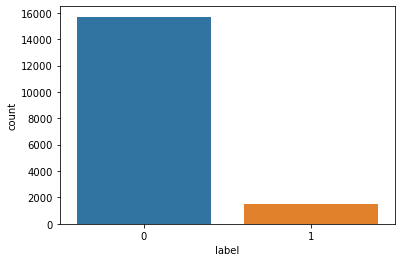

In [113]:
sns.countplot(pd.read_csv('result.csv')['label'])

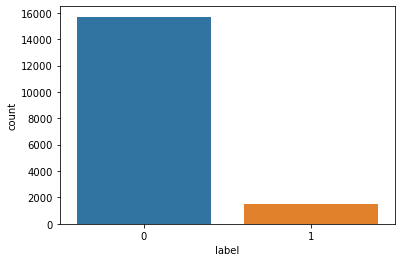

In [123]:
sns.countplot(test['label'])

In [122]:
#accurate enough

,id,tweet,label
0,31963,#studiolife #aislife #requires #passion #dedic...,0
1,31964,@user #white #supremacists want everyone to s...,0
2,31965,safe ways to heal your #acne!! #altwaystohe...,0
3,31966,is the hp and the cursed child book up for res...,0
4,31967,"3rd #bihday to my amazing, hilarious #nephew...",0
...,...,...,...
17192,49155,thought factory: left-right polarisation! #tru...,1
17193,49156,feeling like a mermaid ð #hairflip #neverre...,0
17194,49157,#hillary #campaigned today in #ohio((omg)) &am...,0
17195,49158,"happy, at work conference: right mindset leads...",0
